In [170]:
import pandas as pd
import word2vec
import matplotlib
import keras.optimizers as optim
from sklearn.model_selection import train_test_split
%matplotlib inline

# Make Dataset

In [154]:
selected_frames = pd.read_json('data/selected_frames.json')
selected_frames = selected_frames[selected_frames.law.str.len() == 1]
selected_frames.loc[selected_frames.pos_title == '', 'pos_title'] = float('nan')
selected_frames.columns = pd.MultiIndex.from_product([['raw'], selected_frames.columns])

In [155]:
selected_frames['data', 'Arg1'] = selected_frames.raw.pos_title.map(lambda x: next(zip(*x)), na_action='ignore')
selected_frames['data', 'Arg2'] = selected_frames.raw.pos_content.map(lambda x: next(zip(*x)), na_action='ignore')
selected_frames['data', 'Relation'] = selected_frames.raw.law.map(lambda x: x[0])
selected_frames.data.head()

,Arg1,Arg2,Relation
0,NaN,"(七, 年前, ，, 年, 僅, 九, 歲, 及, 八, 歲, 的, 板橋市, 某, 國小,...",殺人罪
1,"(0, ‧, 3, 坪, 喊價, 800萬, 畸零地, 圍籬, 阻, 路, 拆, ！)","(○, ．, 三, 坪, 畸零地, 能, 「, 螞蟻, 吃, 大象, 」, ？, 北市, 議...",道路交通管理處罰條例
2,"(100, cc, 催芽劑奪, 信義, 鄉四, 命)","(信義, 鄉民, 朱明福, ，, 涉嫌, 將, 催芽劑, 摻入, 米酒, ，, 導致, 前,...",殺人罪
3,"(101, 前董座, 林鴻明, 二審, 輕, 判, 1年, 8月)","(前, 台北, 101, 董事長, 林鴻明, ，, 被, 控, 掏空, 股票, 上市, 的,...",證券交易法
4,"(101, 大樓, 前添, 紛爭, 台獨, 大, 旗, 砸傷, 人)","(台北, 101, 大樓, 前, 法輪, 功, 、, 愛國, 同心, 會, 的, 爭端, ，...",傷害罪


In [156]:
selected_frames.data.Arg2.str.len().rename('Content Length').describe()

count    4022.000000
mean      364.675037
std       122.998481
min        41.000000
25%       297.000000
50%       366.000000
75%       444.000000
max       807.000000
Name: Content Length, dtype: float64

In [171]:
dataset = selected_frames.fillna('').sample(frac=1, random_state=42)
trainset, validset = train_test_split(dataset, test_size=0.25, random_state=42)

In [173]:
relation = dataset.data.Relation.unique()
print('# Train set'.ljust(20), '%5d'%len(trainset))
print('# Valid set'.ljust(20), '%5d'%len(validset))
print('# Law in Train'.ljust(20), '%5d'%len(relation))

# Train set           3016
# Valid set           1006
# Law in Train         274


# Word2Vec

In [78]:
corpus = selected_frames.data.Arg1.map(' '.join, na_action='ignore')
corpus.dropna().to_csv('data/corpus.txt', index=None)
corpus = selected_frames.data.Arg2.map(' '.join, na_action='ignore')
corpus.dropna().to_csv('data/corpus.txt', index=None, mode='a')

In [52]:
f_wordvec = 'data/wordvec.txt'

In [56]:
word2vec.word2vec('data/corpus.txt', f_wordvec, binary=0)
wordvec = word2vec.load(f_wordvec)
unk = wordvec.vectors.mean(0)
with open(f_wordvec, 'r+') as f:
    f.read()
    print('<unk>', *('%.6f'%x for x in unk), file=f)
    f.seek(0)
    vocab_size = next(int(n) for n in f.readline().split())
    vocab_size += 1
    f.seek(0)
    print(vocab_size, file=f, end='')

# Train

In [161]:
import model

In [174]:
classifier = model.CNN(maxlen=450, torel=relation)

In [175]:
# opt = optim.RMSprop(lr=1.2e-3)
classifier.compile(loss='categorical_crossentropy',
                   optimizer='RMSprop',
                   metrics=['acc'])
classifier.reset()
hist = classifier.fit(trainset, validset, epochs=50, batch_size=128)

Train on 3016 samples, validate on 1006 samples
Epoch 1/50
3016/3016 [==============================] - 1s - loss: 4.5035 - acc: 0.1446 - val_loss: 4.7318 - val_acc: 0.1521
Epoch 2/50
3016/3016 [==============================] - 1s - loss: 4.1130 - acc: 0.1548 - val_loss: 4.5243 - val_acc: 0.1918
Epoch 3/50
3016/3016 [==============================] - 1s - loss: 3.8759 - acc: 0.1979 - val_loss: 4.3288 - val_acc: 0.2416
Epoch 4/50
3016/3016 [==============================] - 1s - loss: 3.6046 - acc: 0.2626 - val_loss: 4.0536 - val_acc: 0.2893
Epoch 5/50
3016/3016 [==============================] - 1s - loss: 3.3801 - acc: 0.2997 - val_loss: 3.8179 - val_acc: 0.3111
Epoch 6/50
3016/3016 [==============================] - 1s - loss: 3.1906 - acc: 0.3339 - val_loss: 3.6673 - val_acc: 0.3648
Epoch 7/50
3016/3016 [==============================] - 1s - loss: 3.0190 - acc: 0.3733 - val_loss: 3.4776 - val_acc: 0.3976
Epoch 8/50
3016/3016 [==============================] - 1s - loss: 2.8326 - a

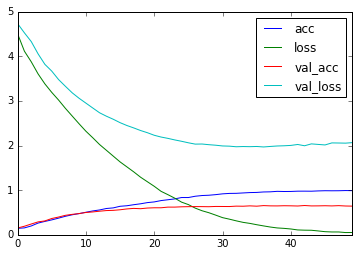

In [176]:
pd.DataFrame(hist.history).plot()

## Residue

In [194]:
res = model.CNN(maxlen=450, torel=relation, residue=True)

In [197]:
# opt = optim.RMSprop(lr=1.2e-3)
res.compile(loss='categorical_crossentropy',
            optimizer='RMSprop',
            metrics=['acc'])
res.reset()
hist_res = res.fit(trainset, validset, epochs=50, batch_size=128)

Train on 3016 samples, validate on 1006 samples
Epoch 1/50
3016/3016 [==============================] - 2s - loss: 4.4595 - acc: 0.1353 - val_loss: 4.5174 - val_acc: 0.1521
Epoch 2/50
3016/3016 [==============================] - 1s - loss: 4.1736 - acc: 0.1515 - val_loss: 4.3856 - val_acc: 0.2028
Epoch 3/50
3016/3016 [==============================] - 1s - loss: 3.9890 - acc: 0.1850 - val_loss: 4.0844 - val_acc: 0.2634
Epoch 4/50
3016/3016 [==============================] - 1s - loss: 3.7353 - acc: 0.2520 - val_loss: 3.7746 - val_acc: 0.2982
Epoch 5/50
3016/3016 [==============================] - 1s - loss: 3.5094 - acc: 0.2984 - val_loss: 3.5569 - val_acc: 0.3250
Epoch 6/50
3016/3016 [==============================] - 1s - loss: 3.2997 - acc: 0.3501 - val_loss: 3.3602 - val_acc: 0.3638
Epoch 7/50
3016/3016 [==============================] - 1s - loss: 3.0910 - acc: 0.3859 - val_loss: 3.1916 - val_acc: 0.3996
Epoch 8/50
3016/3016 [==============================] - 1s - loss: 2.8882 - a

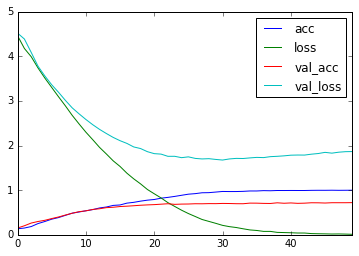

In [199]:
pd.DataFrame(hist_res.history).plot()